In [1]:
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

from utility import *

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
LOOKBACK = 61
TRAIN_SPLIT_RATIO = 0.9
columns = [OPEN_INDEX, HIGH_INDEX, LOW_INDEX, CLOSE_INDEX, VOLUME_INDEX]

In [4]:
todays_date = datetime.now().strftime('%Y-%m-%d')
download_monthly_klines('spot', [BTC], ['15m'], '2019-01-01', todays_date, 'train')

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-01.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-02.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-03.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-04.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-05.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-06.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-07.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-08.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-09.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-10.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-11.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-12.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2020-01.zip

file already exists! /content/train/BTC

In [5]:
dataframe = get_data('train', BTC)

train/BTCUSDT/BTCUSDT-15m-2019-01.csv
train/BTCUSDT/BTCUSDT-15m-2019-02.csv
train/BTCUSDT/BTCUSDT-15m-2019-03.csv
train/BTCUSDT/BTCUSDT-15m-2019-04.csv
train/BTCUSDT/BTCUSDT-15m-2019-05.csv
train/BTCUSDT/BTCUSDT-15m-2019-06.csv
train/BTCUSDT/BTCUSDT-15m-2019-07.csv
train/BTCUSDT/BTCUSDT-15m-2019-08.csv
train/BTCUSDT/BTCUSDT-15m-2019-09.csv
train/BTCUSDT/BTCUSDT-15m-2019-10.csv
train/BTCUSDT/BTCUSDT-15m-2019-11.csv
train/BTCUSDT/BTCUSDT-15m-2019-12.csv
train/BTCUSDT/BTCUSDT-15m-2020-01.csv
train/BTCUSDT/BTCUSDT-15m-2020-02.csv
train/BTCUSDT/BTCUSDT-15m-2020-03.csv
train/BTCUSDT/BTCUSDT-15m-2020-04.csv
train/BTCUSDT/BTCUSDT-15m-2020-05.csv
train/BTCUSDT/BTCUSDT-15m-2020-06.csv
train/BTCUSDT/BTCUSDT-15m-2020-07.csv
train/BTCUSDT/BTCUSDT-15m-2020-08.csv
train/BTCUSDT/BTCUSDT-15m-2020-09.csv
train/BTCUSDT/BTCUSDT-15m-2020-10.csv
train/BTCUSDT/BTCUSDT-15m-2020-11.csv
train/BTCUSDT/BTCUSDT-15m-2020-12.csv
train/BTCUSDT/BTCUSDT-15m-2021-01.csv
train/BTCUSDT/BTCUSDT-15m-2021-02.csv
train/BTCUSD

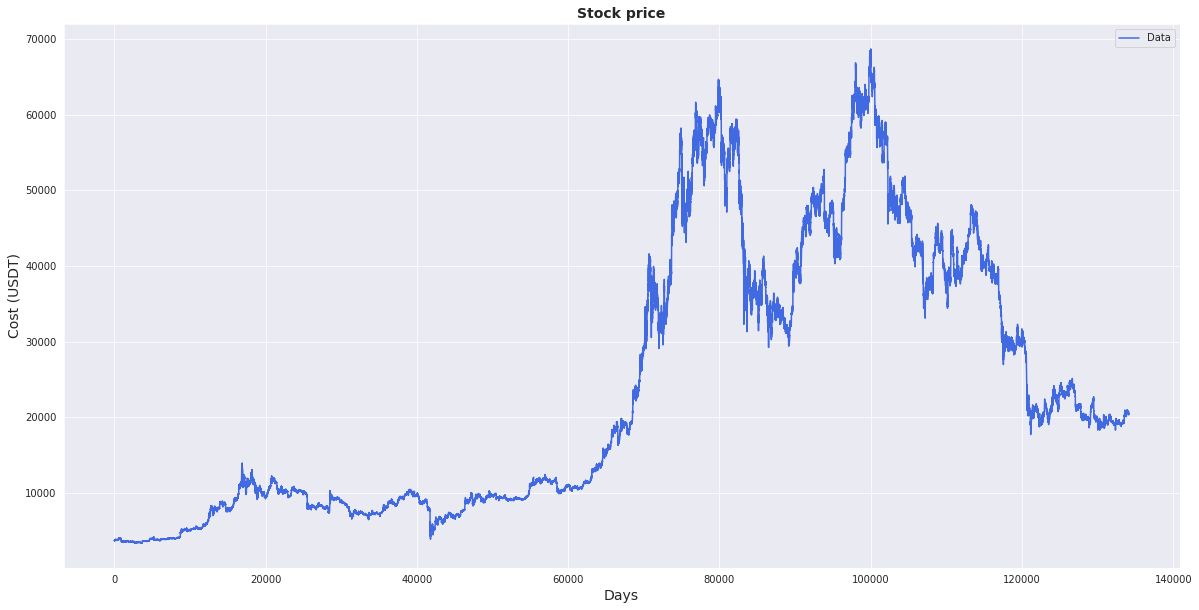

In [6]:
dataframe = dataframe[dataframe[IGNORE_INDEX] == 0]
plot_graph(pd.DataFrame(dataframe[CLOSE_INDEX].values))

In [7]:
scalers = {}
for col in columns:
    scaler = MinMaxScaler().fit(dataframe[[col]])
    dataframe[col] = scaler.transform(dataframe[[col]])
    scalers[col] = scaler

dataframe = dataframe[columns]

In [8]:
x_train, y_train, x_test, y_test = split_data(dataframe, LOOKBACK, TRAIN_SPLIT_RATIO, CLOSE_INDEX-1)

print('x_train.shape = {}'.format(x_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('x_test.shape = {}'.format(x_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

x_train.shape = (120668, 60, 5)
y_train.shape = (120668,)
x_test.shape = (13407, 60, 5)
y_test.shape = (13407,)


In [9]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [10]:
input_dim = x_train.shape[1]
n_features = x_train.shape[2]
output_dim = 1

batch_size = 1000

In [11]:
cnn_lstm = tf.keras.Sequential()

cnn_lstm.add(tf.keras.layers.Conv1D(128, 3, activation='relu', input_shape=(input_dim, n_features)))
cnn_lstm.add(tf.keras.layers.Conv1D(256, 3, activation='relu'))
cnn_lstm.add(tf.keras.layers.LSTM(64, return_sequences=True))
cnn_lstm.add(tf.keras.layers.LSTM(256))
cnn_lstm.add(tf.keras.layers.Dense(1))

cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 128)           2048      
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 256)           98560     
                                                                 
 lstm (LSTM)                 (None, 56, 64)            82176     
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 511,745
Trainable params: 511,745
Non-trainable params: 0
_________________________________________________________________


In [12]:
cnn_lstm.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [13]:
cnn_lstm.fit(x_train, y_train, epochs=10)

Epoch 1/10
3771/3771 [==============================] - 42s 9ms/step - loss: 0.0073 - root_mean_squared_error: 0.0169
Epoch 2/10
3771/3771 [==============================] - 35s 9ms/step - loss: 0.0045 - root_mean_squared_error: 0.0074
Epoch 3/10
3771/3771 [==============================] - 36s 9ms/step - loss: 0.0036 - root_mean_squared_error: 0.0060
Epoch 4/10
3771/3771 [==============================] - 34s 9ms/step - loss: 0.0029 - root_mean_squared_error: 0.0049
Epoch 5/10
3771/3771 [==============================] - 35s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0045
Epoch 6/10
3771/3771 [==============================] - 34s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0042
Epoch 7/10
3771/3771 [==============================] - 33s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0040
Epoch 8/10
3771/3771 [==============================] - 34s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0037
Epoch 9/10
3771/3771 [==============================] - 

In [19]:
cnn_lstm.evaluate(x_test, y_test)

419/419 [==============================] - 3s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0019


[0.001576357171870768, 0.0019215239444747567]

In [15]:
y_train_pred = cnn_lstm.predict(x_train)

3771/3771 [==============================] - 17s 4ms/step


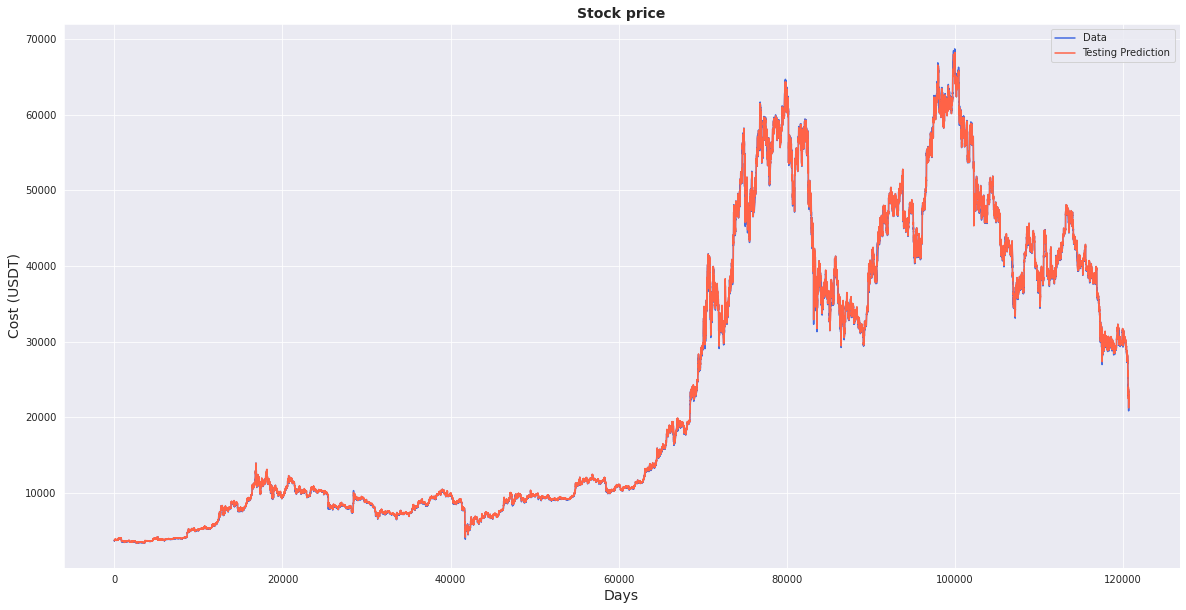

In [16]:
plot_graph(pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_train.numpy().reshape(-1, 1))), 
           pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_train_pred.reshape(-1, 1))))

In [17]:
y_test_pred = cnn_lstm.predict(x_test)

419/419 [==============================] - 2s 4ms/step


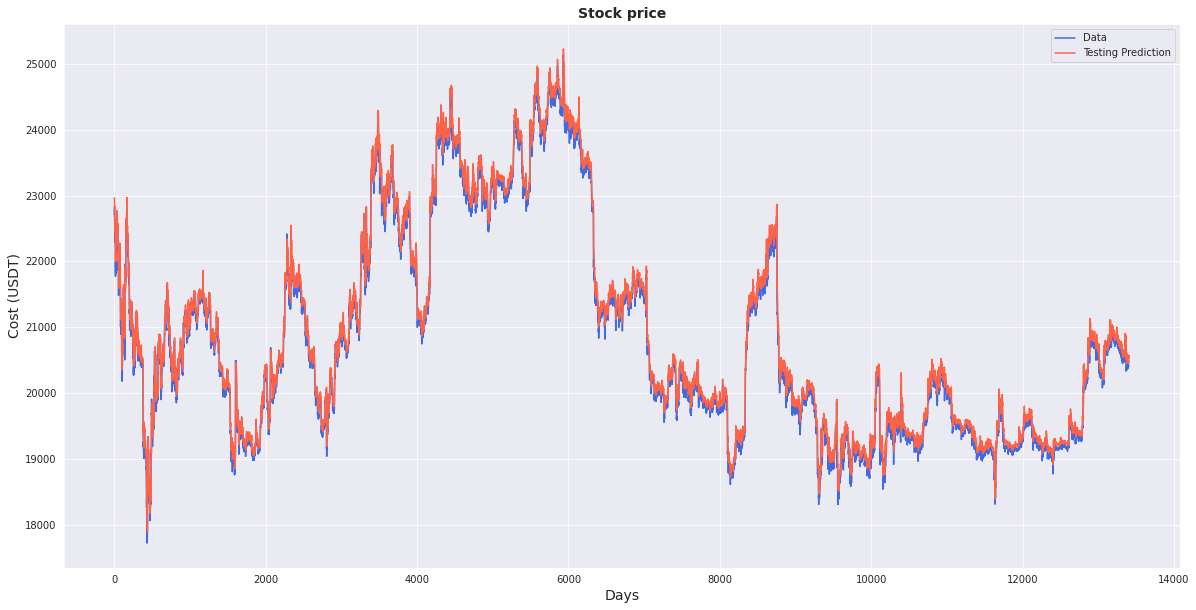

In [18]:
plot_graph(pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_test.numpy().reshape(-1, 1))), 
           pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_test_pred.reshape(-1, 1))))